In [1]:
from Obstacle import *
from Visualization import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Utils.Node import *
import math
import queue
import random
import copy

wheel_radius = 0.038
wheel_distance = 0.354

In [2]:
def halfRound(n):
    return round(2*n)/2
def toRadian(angle):
    return np.pi * angle / 180
def toDegree(angle):
    return 180 * angle / np.pi

In [46]:
def visualize(viz, traversed_nodes, goal_node, obs, show_pass):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set(xlim=(0, 10), ylim = (0,10))
    ax = viz.addObstacles2Map(ax)
    ax.set_aspect("equal")
    c = 0
    print(len(traversed_nodes))
    if show_pass:
        for node in traversed_nodes:
            start_node  = node.getParent()
            if start_node is not None:
                xi, yi, _, _ = start_node.getState()
                points = node.getPathArray()
                if points is not None:
                    for point in points:
                        xn, yn = point
                        ax.plot([xi, xn], [yi, yn], color="blue", linewidth = 0.3)
                        xi, yi = xn, yn
    
    current_node = copy.copy(goal_node)
    nodes = []
    while(current_node.getParent() is not None):
        nodes.append(current_node)
        current_node = current_node.getParent()
    nodes.append(current_node)
    nodes.reverse()

    for node in nodes:
        start_node  = node.getParent()
        
        if start_node is not None:
            xi, yi, _, _ = start_node.getState()
            points = node.getPathArray()
            if points is not None:
                for point in points:
                    xn, yn = point                  
                    ax.plot([xi, xn], [yi, yn], color="green", linewidth = 2)
                    xi, yi = xn, yn
    return nodes


In [38]:
def getBranches(node, T, u_linear, u_steer1, u_steer2, obs):
    actions=[[u_linear, 0], [u_linear, u_steer1], [u_linear, -u_steer1], [u_linear, u_steer2], [u_linear, -u_steer2]]
    state = node.getState()
    branches = []

    for action in actions:
        new_state, path_array, cost = move(state, action, T, obs)
        if new_state is not None:
            branch_node = Node(new_state, node, action, node.getCost() + cost, path_array)
            branches.append(branch_node)
              
    return branches

In [39]:
def isOnSpot(current, final):
    x_current, y_current, theta_current = current.getState()[:3]
    x_goal, y_goal, theta_goal = final.getState()[:3]

    c = y_goal - x_goal*math.tan(theta_goal)
    error = y_current - x_current*math.tan(theta_current) - c
    d, _ = calculate_d_and_theta(current.getState(), final.getState())
    # print(d)
    if (abs(error) < 0.5 and d <= 2):
        return True
    return False

In [40]:
def move(state, action, T, obs):
    t = 0
    dt = 0.1
    
    Xi, Yi, thetai, steeri = state
    thetai = toRadian(thetai)
    steeri = toRadian(steeri)

    u_linear, u_steer = action 

    Xn = Xi
    Yn = Yi
    thetan = thetai
    steern = steeri

    path_array = []
    cost = 0.0
    path_array.append([Xn, Yn])
    a = 1
    while t<T:
        t = t + dt
        steern += dt * u_steer
        if steern > np.pi / 4:
            steern = np.pi / 4
        if steern < -np.pi / 4:
            steern = -np.pi / 4

        thetan += (np.tan(steern) / a ) * u_linear * dt
        dx = u_linear * math.cos(thetan) * dt
        dy = u_linear * math.sin(thetan) * dt

        Xn += dx
        Yn += dy

        cost += math.sqrt(math.pow(dx,2) + math.pow(dy,2))
        path_array.append([Xn, Yn])

        if obs.isInObstacleSpace(Xn, Yn):
            return None, None, None
        
    thetan = int(toDegree(thetan))
    steern = int(toDegree(steern))
    return [Xn, Yn, thetan, steern] , path_array, cost

In [43]:
def getRandomNode():
    a = random.uniform(-np.pi, np.pi)
    # print(a)
    state = [random.uniform(0, 9), random.uniform(0,9), random.uniform(0, 360), 0]
    return Node(state, None, None, None, None)

def getNearestNodeIndex(node_list, random_point):
    distance = []
    # print(random_point)
    for node in node_list:
        node_pts = node.getState()
        alpha = 0.2
        d = (((node_pts[0] - random_point[0])**2 + (node_pts[1] - random_point[1])**2) + alpha *(np.abs(node_pts[2] - random_point[2]))) ** 0.5
        distance.append(d)
    min_idx = distance.index(min(distance))

    return min_idx

def calculate_d_and_theta(start, end):
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    d = math.hypot(dx, dy)
    theta = math.atan2(dy, dx)
    return d, theta

def getNewNode(nearest_node, random_point, obs):
    T = 0.5
    u_linear = 0.5
    u_steer1 = 0.2
    u_steer2 = 0.5
    sample_distance = 0.25

    nearest_point = nearest_node.getState()

    if obs.isInObstacleSpace(nearest_point[0], nearest_point[1]):
        print('Nearest point in OBSTACLE SPACE')
    
    _, theta = calculate_d_and_theta(nearest_point, random_point)
    ref_state = [sample_distance*math.cos(theta), sample_distance*math.sin(theta), random_point[2], 0]

    branches = getBranches(nearest_node, T, u_linear, u_steer1, u_steer2, obs)
    if (len(branches) > 0):
        branch_idx = getNearestNodeIndex(branches, ref_state)
        new_node = branches[branch_idx]
    else:
        new_node = None

    return new_node


In [44]:
height, width = 10, 10
T = 1
dt = 0.1
threshold = 0.5
rand_map = [width-1, height-1]
start_point = [9,9,180,0]
goal_state = [5,7,270,0]
obs = Obstacle(0.0)
viz = Visualization(obs)

node_array = np.array([[[math.inf for k in range(360)] for j in range(int(height/threshold))] for i in range(int(width/threshold))])

goal_reached = False
start_node = Node(start_point, None, None, 0, [])
goal_node = Node(goal_state, None, None, math.inf, [])
final_node = None
node_list = [start_node]
goal_node_final = None
destination = None

# fig, ax = plt.subplots(figsize = (10, 10))
# ax.set(xlim=(0, 10), ylim = (0,10))
# ax = viz.addObstacles2Map(ax)
# ax.set_aspect("equal")
# c = 0

for i in range(3000):
    random_node = getRandomNode()
    if (random_node == None):
        continue
    # ax.scatter(random_node.getState()[0], random_node.getState()[1])
    nearest_idx = getNearestNodeIndex(node_list, random_node.getState())
    nearest_node = node_list[nearest_idx]

    new_node = getNewNode(nearest_node, random_node.getState(), obs)
    if (new_node == None):
        continue

    node_list.append(new_node)
    x_new = int(halfRound(new_node.getState()[0])/threshold)
    y_new = int(halfRound(new_node.getState()[1])/threshold)
    d_goal = ((node_list[-1].getState()[0]- goal_state[0])**2 + (node_list[-1].getState()[1]- goal_state[1])**2)**0.5 
    d_angle = np.abs((node_list[-1].getState()[2]- goal_state[2]))

    is_on_spot = isOnSpot(node_list[-1], goal_node) 
    if (is_on_spot and d_angle < 5):
        print('Final node get state = ',new_node.getState())
        if not obs.isInObstacleSpace(new_node.getState()[0], new_node.getState()[1]):
            print('Goal Reached, cost = ', new_node.getCost())
            x_goal = int(halfRound(goal_node.getState()[0])/threshold)
            y_goal = int(halfRound(goal_node.getState()[1])/threshold)
            print(node_array[x_goal, y_goal, 0])
            if (new_node.getCost() <  node_array[x_goal, y_goal, 0]):
                print('Update final node cost, state = ', x_goal, ', ',y_goal)
                print('from: ', node_array[x_goal, y_goal, 0], ' to :', new_node.getCost())
                node_array[x_goal,y_goal,0] = new_node.getCost() 
                goal_node_final = new_node
            print('------------------------')

# steer to goal
if goal_node_final is not None:
    node_list.append(goal_node_final)
    destination = getNewNode(goal_node_final, goal_node.getState(), obs)
    node_list.append(destination)

Final node get state =  [4.554570380391455, 7.60433481542317, 267, 14]
Goal Reached, cost =  5.75
inf
Update final node cost, state =  10 ,  14
from:  inf  to : 5.75
------------------------


2581


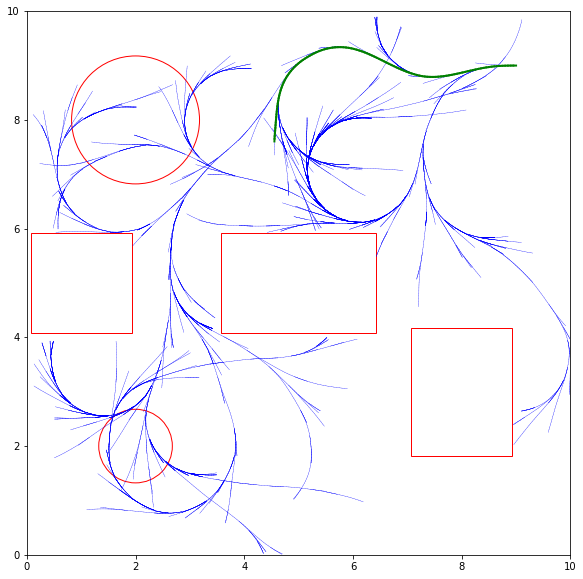

In [48]:
# node_list.append( goal_node_final)
if goal_node_final is None:
    goal_node_final = goal_node
nodes = visualize(viz, node_list, goal_node_final, obs, True)

# Debugging 180 degree issue

In [44]:
height, width = 10, 10
T = 0.5
dt = 0.1
threshold = 0.5
rand_map = [width-1, height-1]
start_point = [4,2,90,0]
obs = Obstacle(0.0)
viz = Visualization(obs)
start_node = Node(start_point, None, None, 0, [])

T = 1
u_linear = 1
u_steer1 = 0.5
u_steer2 = 0.7

In [45]:
branches = getBranches(start_node, T, u_linear, u_steer1, u_steer2, obs)

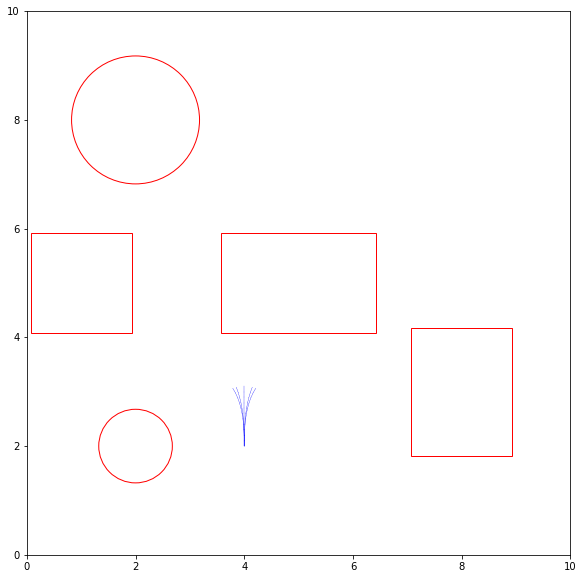

In [46]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set(xlim=(0, 10), ylim = (0,10))
ax = viz.addObstacles2Map(ax)
ax.set_aspect("equal")
for node in branches:
    start_node  = node.getParent()
    if start_node is not None:
        xi, yi, _, _ = start_node.getState()
        points = node.getPathArray()
        if points is not None:
            for point in points:
                xn, yn = point
                ax.plot([xi, xn], [yi, yn], color="blue", linewidth = 0.3)
                xi, yi = xn, yn